In [1]:
from __future__ import print_function
import os
import shutil
import random

import pandas as pd

from PIL import Image
import numpy as np

import chainer
from chainer.dataset import convert
import chainer.links as L
import chainer.functions as F
import chainer.initializers as I
from chainer import serializers

import utils

Using TensorFlow backend.
/home/fytroo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### ハイパーパラメータ

In [2]:
from easydict import EasyDict
args = EasyDict({
    'src_dir' : 'datasets/birds-dataset',
    'bs': 32, 
    'epoch' : 100,
    'lr' : 0.001,
    'gpu': 0,
    'out': 'result',
    'resume': '',
    'img_size': 128,
})
try:
    __file__.endswith('py')
    import argparse
    parser = argparse.ArgumentParser(description='Chainer example: MNIST')
    parser.add_argument('--batchsize', '-b', dest='bs', type=int, default=args.bs,
                        help='Number of images in each mini-batch')
    parser.add_argument('--epoch', '-e', type=int, default=args.epoch,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--learningrate', '-l', dest='lr', type=float, default=args.lr,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--frequency', '-f', type=int, default=-1,
                        help='Frequency of taking a snapshot')
    parser.add_argument('--gpu', '-g', type=int, default=args.gpu,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default=args.out,
                        help='Directory to output the result')
    parser.add_argument('--resume', '-r', default=args.resume,
                        help='Resume the training from snapshot')
    parser.add_argument('--unit', '-u', dest='n_in', type=int, default=args.n_in,
                        help='Number of units')
    parser.add_argument('--noplot', dest='plot', action='store_false',
                        help='Disable PlotReport extension')
    args = parser.parse_args()
except:
    print('no argsparse')
    pass

no argsparse


In [3]:
from tuner.dataset import ClassificationDataset, AugmentDataset
from tuner import net
from tuner import utils
from tuner.utils import maxmin_normalize
from tuner.load_data import arr2img 

In [4]:
birds_dataset = ClassificationDataset(args.src_dir)

df = birds_dataset.df
df_finch = df[df['label'].str.contains('finch')]
df_finch['length'] = np.random.normal(25.5, 3, len(df_finch))
df_finch['weight'] = np.random.normal(85, 10, len(df_finch))

df_parrot = df[df['label'].str.contains('parrot')]
df_parrot['length'] = np.random.normal(55.5, 1, len(df_parrot))
df_parrot['weight'] = np.random.normal(850, 100, len(df_parrot))

df = pd.concat([df_finch, df_parrot])
df = df[['handle', 'length', 'weight']]

df.to_csv(os.path.join(args.src_dir, 'numeric_data.csv'), index=False)

/home/fytroo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/fytroo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fytroo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

## ここまでデータセットの作成，ここから学習をはじめる

### モデルを定義

In [8]:
class LeNet(chainer.Chain):
    def __init__(self, n_out=10):
        super(LeNet, self).__init__()
        
        initialW= I.HeNormal()
        with self.init_scope():
            self.conv0 = L.Convolution2D(None, 16, 1, 1, 0, initialW=initialW, nobias=True)
            
            self.bn11 = L.BatchNormalization(16)
            self.conv11 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn12 = L.BatchNormalization(32)
            self.conv12 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.bn21 = L.BatchNormalization(32)
            self.conv21 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn22 = L.BatchNormalization(64)
            self.conv22 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.conv_out = L.Convolution2D(None, n_out)
            self.fc = L.Linear(None, n_out)
    
    def __call__(self, x):
        h = x
        h = self.conv0(h)
        
        h = self.bn11(h)
        h = F.relu(h)
        h = self.conv11(h)
        h = self.bn12(h)
        h = F.relu(h)
        h = self.conv12(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        
        h = self.bn21(h)
        h = F.relu(h)
        h = self.conv21(h)
        h = self.bn22(h)
        h = F.relu(h)
        h = self.conv22(h)
        
        print('#1', h.shape)
        h = self.conv_out(h)
        print('#2', h.shape)
        h = F.squeeze(F.average_ppoling_2d(h,4))
        print('#3', h.shape)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        print('#4', h.shape)
        h = self.fc(h)
        
        return h

In [9]:
class LeNet(chainer.Chain):
    def __init__(self, n_out=10):
        super(LeNet, self).__init__()
        
        initialW= I.HeNormal()
        with self.init_scope():
            self.conv0 = L.Convolution2D(None, 16, 1, 1, 0, initialW=initialW, nobias=True)
            
            self.bn11 = L.BatchNormalization(16)
            self.conv11 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn12 = L.BatchNormalization(32)
            self.conv12 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.bn21 = L.BatchNormalization(32)
            self.conv21 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn22 = L.BatchNormalization(64)
            self.conv22 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.conv_out = L.Convolution2D(None, n_out)
            self.fc = L.Linear(None, 20)
            self.l1 = L.Linear(None, 20)
            self.l2 = L.Linear(None, n_out)
    
    def __call__(self, x, u):
        h = x
        h = self.conv0(h)
        
        h = self.bn11(h)
        h = F.relu(h)
        h = self.conv11(h)
        h = self.bn12(h)
        h = F.relu(h)
        h = self.conv12(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(h, ratio=0.4)
        
        h = self.bn21(h)
        h = F.relu(h)
        h = self.conv21(h)
        h = self.bn22(h)
        h = F.relu(h)
        h = self.conv22(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(h, ratio=0.5)
        
        h = self.fc(h)
        #h = F.relu(h)
        h = F.dropout(h, ratio=0.5)
        h = F.concat((h, u), axis=1)
        h = F.dropout(h, ratio=0.8)
        h = self.l1(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.6)
        h = self.l2(h)
        
        return h

In [5]:
birds_dataset = ClassificationDataset(args.src_dir)

In [11]:
n_label = birds_dataset.n_label 
model = L.Classifier(LeNet(n_label),
                    lossfun=F.softmax_cross_entropy,
                    accfun=F.accuracy)
xp = np
if args.gpu >= 0:
    import cupy as cp
    xp = cp
    chainer.cuda.get_device_from_id(args.gpu).use()
    model.to_gpu()  # Copy the model to the GPU
optimizer = chainer.optimizers.Adam(args.lr)
optimizer.setup(model)

In [85]:
df_num = pd.read_csv(os.path.join(args.src_dir, 'numeric_data.csv'))
df_train = pd.merge(birds_dataset.df_train, df_num, on='handle',how='left')
df_validation = pd.merge(birds_dataset.df_validation, df_num, on='handle',how='left')
u_train = df_train[['length','length']].values
u_val = df_validation[['length','length']].values

birds_dataset.load_data(resize=args.img_size, rescale=1)
x_train, y_train = birds_dataset.train_data
x_val, y_val = birds_dataset.validation_data

### data augmentation

In [86]:
import Augmentor
p = Augmentor.Pipeline()
p.crop_random(probability=1, percentage_area=0.8)
p.resize(probability=1, width=args.img_size, height=args.img_size)
p.flip_left_right(probability=0.5)
p.random_erasing(probability=0.5, rectangle_area=0.5)
p.shear(probability=0.3, max_shear_left=2, max_shear_right=2)

g = p.keras_generator_from_array(\
    birds_dataset.x_train,
    birds_dataset.y_train,
    batch_size=args.bs)

In [87]:
def gen_batch(x_data, u_data, y_data, bs=10):
    while True:
        batch = random.sample(list(zip(x_data, u_data, y_data)), bs)
        xs, us, ys = np.array(batch).T
        xs = np.array(xs.tolist())
        us = np.array(us.tolist())
        ys = np.array(ys.tolist())
        yield xs, us, ys

(32, 128, 128, 3) (32, 2) (32,)


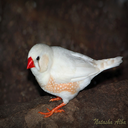

In [88]:
g = gen_batch(x_train, u_train, y_train, args.bs)

xs, us, ys = next(g)
print(xs.shape, us.shape, ys.shape)

arr2img(xs[9])

In [103]:
def transform_data(xs, us, ys):
    xs = xp.array(np.swapaxes(xs/255., 1, 3).astype(np.float32))
    us = xp.array(maxmin_normalize(us).astype(np.float32))
    ys = xp.array(ys.astype(np.int8))
    fit_chainer = (
        chainer.Variable(xs),
        chainer.Variable(us),
        chainer.Variable(ys))
    return fit_chainer

In [89]:
input_g = ( transform_data(xs, us, ys) for (xs, us, ys) in g)

### 訓練と検証

In [91]:
def train(step=None, step_per_print=100):
    x, u, t = next(input_g) 
    optimizer.update(model, x, u, t)
    with chainer.using_config('train', True):
        loss = model(x,u,t)

    loss = float(loss.data)
    acc = float(model.accuracy.data)

    if step%step_per_print==0:
        print('step:{}'.format(step))
        print('loss: {:.4f}\t acc: {:.4f}'.format(loss, acc))
    
def validation(step=None):
    x, u, t = transform_data(x_val, u_val, y_val)
    with chainer.using_config('train', False):
        loss = model(x,u,t)

    loss = float(loss.data)
    acc = float(model.accuracy.data)
    
    print('val_loss: {:.4f}\t val_acc: {:.4f}'.format(loss, acc))

In [92]:
if __name__ == '__main__':
    #for step in range(args.epoch):
    for step in range(10**5):
        train(step)
        if step%1000==0:
            validation(step)

step:0
loss: 22.6925	 acc: 0.1250
val_loss: 12.2037	 val_acc: 0.1970
step:100
loss: 5.4027	 acc: 0.1875
step:200
loss: 3.5210	 acc: 0.1250
step:300
loss: 3.2210	 acc: 0.2500
step:400
loss: 3.5401	 acc: 0.1562
step:500
loss: 2.5689	 acc: 0.1875
step:600
loss: 2.1899	 acc: 0.4062
step:700
loss: 1.7297	 acc: 0.3750
step:800
loss: 1.6594	 acc: 0.3438
step:900
loss: 2.0386	 acc: 0.2500
step:1000
loss: 1.6896	 acc: 0.1562
val_loss: 1.5679	 val_acc: 0.2576
step:1100
loss: 1.6861	 acc: 0.3125
step:1200
loss: 1.9293	 acc: 0.1875
step:1300
loss: 1.5499	 acc: 0.2500
step:1400
loss: 1.6182	 acc: 0.3438
step:1500
loss: 1.8378	 acc: 0.3438
step:1600
loss: 1.5985	 acc: 0.2500
step:1700
loss: 1.5006	 acc: 0.4062
step:1800
loss: 1.7701	 acc: 0.2812
step:1900
loss: 1.5633	 acc: 0.4375
step:2000
loss: 1.8075	 acc: 0.2500
val_loss: 1.5576	 val_acc: 0.2727
step:2100
loss: 1.8255	 acc: 0.2812
step:2200
loss: 1.4182	 acc: 0.4062
step:2300
loss: 1.9604	 acc: 0.2812
step:2400
loss: 1.5107	 acc: 0.3438
step:250

KeyboardInterrupt: 

In [94]:
model.to_cpu()

from chainer import serializers
serializers.save_hdf5('models/birds_online.180110.hdf5', model)

In [102]:
m(transform_data(x_train, u_train, y_train))

TypeError: __call__() missing 2 required positional arguments: 'x' and 'u'

In [96]:
import pickle
with open('models/birds_online.model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [99]:
with open('models/birds_online.model.pkl', 'rb') as f:
    m = pickle.load(f)

In [100]:
next(g)

(array([[[[215, 214, 213],
          [231, 232, 226],
          [236, 237, 231],
          ..., 
          [231, 231, 231],
          [229, 229, 229],
          [224, 223, 223]],
 
         [[215, 215, 213],
          [233, 234, 227],
          [237, 238, 232],
          ..., 
          [234, 234, 234],
          [231, 230, 231],
          [224, 223, 223]],
 
         [[214, 214, 212],
          [234, 235, 229],
          [240, 241, 235],
          ..., 
          [236, 236, 234],
          [234, 234, 232],
          [229, 229, 229]],
 
         ..., 
         [[211, 210, 208],
          [228, 228, 222],
          [233, 234, 228],
          ..., 
          [226, 225, 225],
          [222, 221, 220],
          [215, 214, 213]],
 
         [[210, 210, 207],
          [227, 227, 221],
          [232, 233, 227],
          ..., 
          [224, 223, 224],
          [220, 219, 220],
          [214, 214, 213]],
 
         [[212, 211, 209],
          [230, 230, 224],
          [232, 233, 227],

In [95]:
serializers.load_hdf5('models/birds_online.180110.hdf5', m)

NameError: name 'm' is not defined